<a href="https://colab.research.google.com/github/bhanup6663/COMP691_DL/blob/main/challenge_2_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Cell 1
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.datasets import STL10



In [5]:
# Cell 2:

def load_external_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    external_train_set = STL10(root='./data', split='train', download=True, transform=transform)
    external_unlabeled_set = STL10(root='./data', split='unlabeled', download=True, transform=transform)
    return DataLoader(external_train_set, batch_size=10, shuffle=True), DataLoader(external_unlabeled_set, batch_size=10, shuffle=True)

external_train_loader, external_unlabeled_loader = load_external_data()

100%|██████████| 2640397119/2640397119 [06:08<00:00, 7161120.55it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Cell 3:
def load_model(num_classes=10):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = load_model(num_classes=10)  # Pre-training with 10 classes from STL-10

def fine_tune_model(model, external_loader, num_classes=10, epochs=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in external_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(external_loader)
        print(f'Epoch {epoch+1}: Average Loss: {avg_loss:.4f}')

fine_tune_model(model, external_train_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.5MB/s]


Epoch 1: Average Loss: 0.4818
Epoch 2: Average Loss: 0.1738
Epoch 3: Average Loss: 0.1098
Epoch 4: Average Loss: 0.0728
Epoch 5: Average Loss: 0.0369


In [7]:
# Cell4
def prepare_data(num_classes=2, samples_per_class=25, val_samples_per_class=5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    all_classes = np.arange(10)  # This represents the 10 classes of CIFAR-10
    selected_classes = np.random.choice(all_classes, num_classes, replace=False)

    class_indices = [i for i in range(len(full_train_set)) if full_train_set.targets[i] in selected_classes]
    train_indices = []
    val_indices = []

    for cls in selected_classes:
        cls_indices = [i for i in class_indices if full_train_set.targets[i] == cls]
        np.random.shuffle(cls_indices)
        train_indices.extend(cls_indices[:samples_per_class])
        val_indices.extend(cls_indices[samples_per_class:samples_per_class+val_samples_per_class])

    class RemappedSubset(torch.utils.data.Dataset):
        def __init__(self, dataset, indices, target_transform=None):
            self.dataset = dataset
            self.indices = indices
            self.target_transform = target_transform

        def __getitem__(self, idx):
            img, target = self.dataset[self.indices[idx]]
            if self.target_transform:
                target = self.target_transform(target)
            return img, target

        def __len__(self):
            return len(self.indices)

    target_transform = lambda x: np.where(selected_classes == x)[0][0]
    train_subset = RemappedSubset(full_train_set, train_indices, target_transform=target_transform)
    val_subset = RemappedSubset(full_train_set, val_indices, target_transform=target_transform)

    train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=10, shuffle=False)

    return train_loader, val_loader, selected_classes

train_loader, val_loader, classes_used = prepare_data(seed=42)


100%|██████████| 170498071/170498071 [00:02<00:00, 69288878.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
def adjust_model_for_cifar10(model, num_classes=2):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = adjust_model_for_cifar10(model, num_classes=len(classes_used))


In [9]:
# Cell 5
def train_model_with_validation(model, train_loader, val_loader, epochs=10, print_interval=2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for batch, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Print for the first and last batch of each epoch only
            if batch == 1 or batch == len(train_loader):
                print(f'Epoch {epoch+1}, Batch {batch}, Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # Validation phase
        val_loss, val_correct, val_total = 0.0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best model found at Epoch {epoch+1} with Validation Accuracy {best_val_acc*100:.2f}%.")

        scheduler.step()

    return model

model = train_model_with_validation(model, train_loader, val_loader, epochs=10)


Epoch 1, Batch 1, Loss: 1.1057
Epoch 1, Batch 5, Loss: 0.5225
Epoch 1: Train Loss: 0.8090, Train Acc: 60.00%, Val Loss: 0.5901, Val Acc: 70.00%
New best model found at Epoch 1 with Validation Accuracy 70.00%.
Epoch 2, Batch 1, Loss: 0.7636
Epoch 2, Batch 5, Loss: 0.7729
Epoch 2: Train Loss: 0.5620, Train Acc: 64.00%, Val Loss: 0.4783, Val Acc: 80.00%
New best model found at Epoch 2 with Validation Accuracy 80.00%.
Epoch 3, Batch 1, Loss: 0.4297
Epoch 3, Batch 5, Loss: 0.3077
Epoch 3: Train Loss: 0.3348, Train Acc: 84.00%, Val Loss: 0.3956, Val Acc: 90.00%
New best model found at Epoch 3 with Validation Accuracy 90.00%.
Epoch 4, Batch 1, Loss: 0.3303
Epoch 4, Batch 5, Loss: 0.1980
Epoch 4: Train Loss: 0.3259, Train Acc: 86.00%, Val Loss: 0.4674, Val Acc: 90.00%
Epoch 5, Batch 1, Loss: 0.1526
Epoch 5, Batch 5, Loss: 0.2338
Epoch 5: Train Loss: 0.2045, Train Acc: 100.00%, Val Loss: 0.3247, Val Acc: 90.00%
Epoch 6, Batch 1, Loss: 0.2560
Epoch 6, Batch 5, Loss: 0.2337
Epoch 6: Train Loss: 0

In [10]:
# Celll 6
# def prepare_filtered_test_data(classes_used, seed=None):
#     if seed is not None:
#         np.random.seed(seed)

#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#     class_indices = [i for i in range(len(test_set)) if test_set.targets[i] in classes_used]

#     class RemappedSubset(torch.utils.data.Dataset):
#         def __init__(self, dataset, indices, target_transform=None):
#             self.dataset = dataset
#             self.indices = indices
#             self.target_transform = target_transform

#         def __getitem__(self, idx):
#             img, target = self.dataset[self.indices[idx]]
#             if self.target_transform:
#                 target = self.target_transform(target)
#             return img, target

#         def __len__(self):
#             return len(self.indices)

#     if isinstance(classes_used, np.ndarray):
#         classes_used = classes_used.tolist()

#     target_transform = lambda x: classes_used.index(x) if x in classes_used else -1
#     remapped_test_subset = RemappedSubset(test_set, class_indices, target_transform=target_transform)
#     test_loader = DataLoader(remapped_test_subset, batch_size=10, shuffle=False)

#     return test_loader

# test_loader = prepare_filtered_test_data(classes_used)

# Cell 6: Prepare Test Data Without Filtering Classes
def prepare_test_data(seed=None):
    if seed is not None:
        np.random.seed(seed)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

    return test_loader

test_loader = prepare_test_data(seed=42)


Files already downloaded and verified


Accuracy of the model on the test images: 17.78%


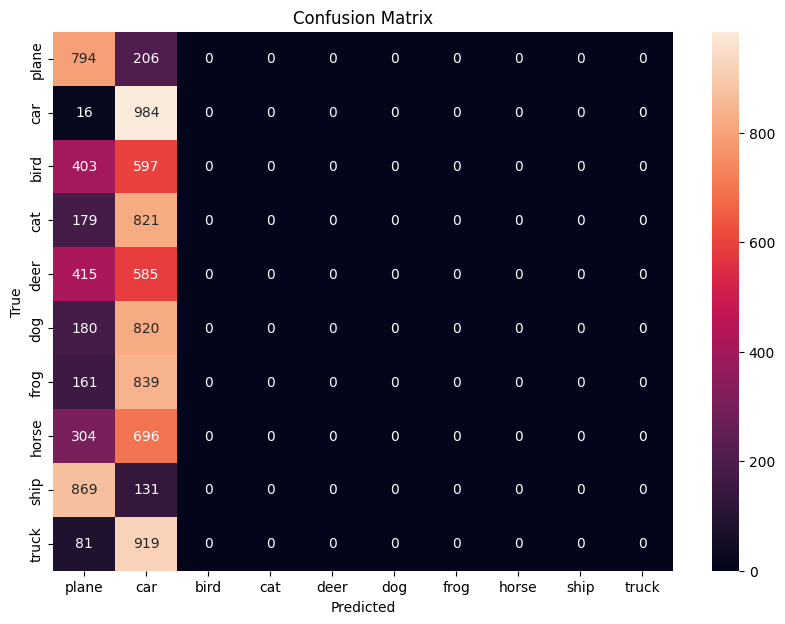

In [11]:
# Cell 7
# def evaluate_model_with_confusion_matrix(model, test_loader, classes):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.eval()

#     correct = 0
#     total = 0
#     all_predictions = []
#     all_labels = []

#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data[0].to(device), data[1].to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             all_predictions.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     accuracy = 100 * correct / total
#     print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

#     class_labels = [classes[i] for i in np.unique(all_labels)]
#     cm = confusion_matrix(all_labels, all_predictions, labels=np.unique(all_labels))
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

# Cell 7: Evaluate Model with Confusion Matrix
def evaluate_model_with_confusion_matrix(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Create confusion matrix using all class labels
    cm = confusion_matrix(all_labels, all_predictions, labels=range(len(classes)))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model_with_confusion_matrix(model, test_loader)


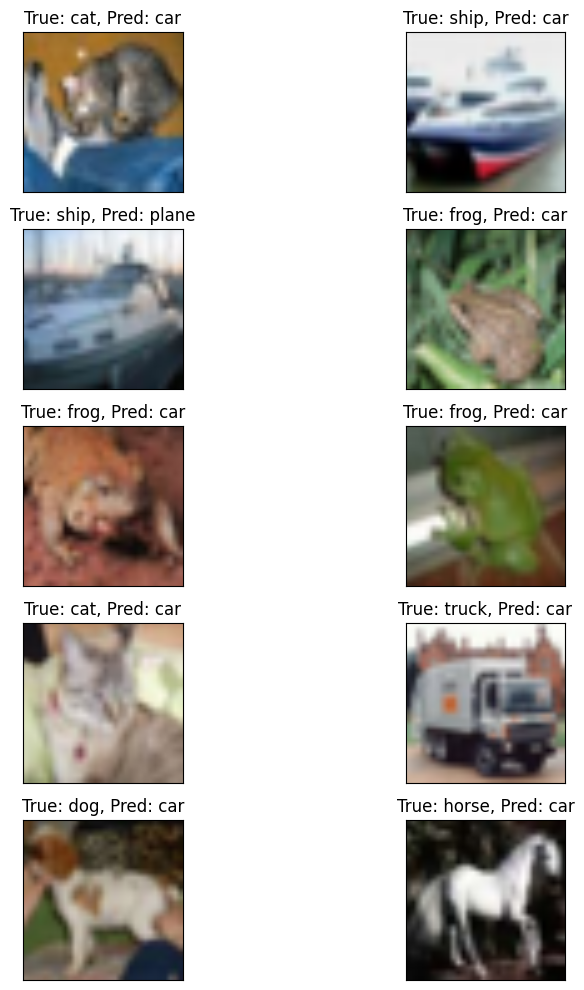

In [12]:
#Cell 8
def show_misclassified_images(model, test_loader, classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    misclassified = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            wrong_indices = predicted != labels
            if any(wrong_indices):
                wrong_images = images[wrong_indices].cpu()
                wrong_labels = labels[wrong_indices].cpu()
                wrong_preds = predicted[wrong_indices].cpu()
                misclassified.extend([(img, pred, true) for img, pred, true in zip(wrong_images, wrong_preds, wrong_labels)])
            if len(misclassified) >= 10:
                break

    plt.figure(figsize=(10, 10))
    for i, (img, pred, true) in enumerate(misclassified[:10]):
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'True: {classes[true]}, Pred: {classes[pred]}')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_misclassified_images(model, test_loader, classes)
